In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

# Exploring reward funcion options

## **Creating a test framework**

In [119]:
class TestGenerator:
    def __init__(
                self,
                number_of_users_to_generate:int,
                total_views_average:int,
                total_unique_views_average:int,
                total_prompts_created_average:int,
                total_curator_views_average:int,
                average_curator_score:int = 10 ,
                number_of_curator_views:int = 5,
                curator_views_compact:bool = True,
                curator_scores_compact:bool = True,
                total_views_compact:bool = True,
                unique_views_compact:bool = True,
                prompts_compact:bool = True,
                compact_factor:float = 0.2,
                extreme_factor:int = 20,
                extreme_perc:float = 0.1,
                curator_scores_extreme:bool = False,
                total_views_extreme:bool = False,
                unique_views_extreme:bool = False,
                prompts_extreme:bool = False,
                curator_scores_constant:bool = False,
                total_views_constant:bool = False,
                unique_views_constant:bool = False,
                prompts_constant:bool = False,

                ):
        '''
        number_of_users_to_generate: self explanatory
        total_views_average: (average) total number of views from all blocks created by the user
        total_unique_views_average: (average) number of unique viewers from all the blacks generated by the user
        total_prompts_created_average: (average) number of blocks referencing all the user generated blocks (could be sandbox additions too)
        number_of_curator_views_average: (average) number of curators that referenced the user's blocks to their curation (could be sandbox additions too)
        reward_function: function that takes some the parameters above and calculates a final score
        X__compact: defines if the numbers will be cluster around the averages (above) or will be totally spread
        compact_factor: the percentage where the random values will be generate from: average_Value * +- compact_factor
        extreme_factor: factor by what I multiply when values are not compacted to create the range from 
                        [1, averege * max I want for the metric to go]
        extreme_perc: percentage of users that should get an extreme value
        X__extreme: determines for that variable if a specigic percentage of users should get a very extreme value
        X__constant: make all the number for a specific block to be constant

        '''
        self.compact_factor = compact_factor
        self.number_of_users_to_genereate = number_of_users_to_generate
        self.total_views_average = total_views_average
        self.total_unique_views_average = total_unique_views_average
        self.total_prompts_created_average = total_prompts_created_average
        self.total_views_compact = total_views_compact
        self.unique_views_compact = unique_views_compact
        self.prompts_compact = prompts_compact
        self.total_curator_views_average = total_curator_views_average
        self.number_of_curator_views = number_of_curator_views
        self.average_curator_score = average_curator_score
        self.extreme_factor = extreme_factor
        self.curator_views_compact = curator_views_compact
        self.curator_scores_compact = curator_scores_compact
        self.simulated_users = None
        self.extreme_perc = extreme_perc
        self.curator_scores_extreme = curator_scores_extreme
        self.total_views_extreme = total_views_extreme
        self.unique_views_extreme = unique_views_extreme
        self.prompts_extreme = prompts_extreme
        self.curator_scores_constant = curator_scores_constant
        self.total_views_constant = total_views_constant
        self.unique_views_constant = unique_views_constant
        self.prompts_constant = prompts_constant




    def generate_users(self, random_seed:int=None):
        simulated_users = []
        tviews_ext_counter = 0
        uvies_ext_counter = 0
        prompts_ext_counter = 0
        curator_ext_counter = 0
        can_distribued_extreme_value = True  #this created a randomness to extremes, otherwise all possible extremes goes to the first user only

        if random_seed:
            random.seed(random_seed)

        for x in range(self.number_of_users_to_genereate):
            user_data = {'id': x}

            #initializing flag variables
            user_data['is_outlier'] = False
            user_data['is_total_views_outlier'] = False
            user_data['is_unique_views_outlier'] = False
            user_data['is_prompts_outlier'] = False
            user_data['is_curator_views_outlier'] = False

            #generating total views
            if self.total_views_extreme and \
                tviews_ext_counter < (self.number_of_users_to_genereate * self.extreme_perc) and \
                can_distribued_extreme_value:
                user_data['total_views'] = self.generate_total_views() * self.extreme_factor
                tviews_ext_counter += 1
                user_data['is_outlier'] = True
                user_data['is_total_views_outlier'] = True
                can_distribued_extreme_value = False
            elif self.total_views_constant:
                user_data['total_views'] = self.total_views_average
            else:
                user_data['total_views'] = self.generate_total_views()
           
           
            #generating unique views
            if self.unique_views_extreme and \
                uvies_ext_counter < (self.number_of_users_to_genereate * self.extreme_perc) and \
                can_distribued_extreme_value:
                user_data['unique_views'] = self.generate_unique_views() * self.extreme_factor
                uvies_ext_counter += 1
                user_data['is_outlier'] = True
                user_data['is_unique_views_outlier'] = True
                can_distribued_extreme_value = False
            elif self.unique_views_constant:
                user_data['unique_views'] = self.total_unique_views_average
            else:
                user_data['unique_views'] = self.generate_unique_views()
     

            #generating number of prompts
            if self.prompts_extreme and \
                prompts_ext_counter < (self.number_of_users_to_genereate * self.extreme_perc) and\
                can_distribued_extreme_value:
                user_data['prompts_created'] = self.generate_prompts_creation() * self.extreme_factor
                prompts_ext_counter += 1
                user_data['is_outlier'] = True
                user_data['is_prompts_outlier'] = True
                can_distribued_extreme_value = False
            elif self.prompts_constant:
                user_data['prompts_created'] = self.total_prompts_created_average
            else:
                user_data['prompts_created'] = self.generate_prompts_creation()
     

            #generating curator view weighted average
            if self.curator_scores_extreme and \
                curator_ext_counter < (self.number_of_users_to_genereate * self.extreme_perc) and \
                can_distribued_extreme_value:
                user_data['curator_views_weighted'] = self.generate_curator_views() * self.extreme_factor
                curator_ext_counter += 1
                user_data['is_outlier'] = True
                user_data['is_curator_views_outlier'] = True
                can_distribued_extreme_value = False
            elif self.curator_scores_constant:
                user_data['curator_views_weighted'] = self.total_curator_views_average
            else:
                user_data['curator_views_weighted'] = self.generate_curator_views()
                
            can_distribued_extreme_value = True
            simulated_users.append(user_data)
        
        self.simulated_users = simulated_users
        
        return simulated_users
    
    def generate_user_with_scores(self, reward_function:object, reward_function_weights:list = [0.1, 0.1, 0.4, 0.4], random_seed:int=None):
        if self.simulated_users == None:
            self.generate_users(random_seed=random_seed)
        
        final_data = []
        for user in self.simulated_users:
            score_function_parameters = {
                'parameters_weights' : reward_function_weights,
                **user
            }
            del score_function_parameters["id"]
            del score_function_parameters["is_outlier"]
            del score_function_parameters["is_curator_views_outlier"]
            del score_function_parameters["is_prompts_outlier"]
            del score_function_parameters["is_unique_views_outlier"]
            del score_function_parameters["is_total_views_outlier"]
            
            #for multiple runs, needs to take this off one every user object will have these attributes
            try:
                del score_function_parameters["final_score"]
                del score_function_parameters['total_views_share'] 
                del score_function_parameters['unique_share'] 
                del score_function_parameters['prompts_share']
                del score_function_parameters['curators_share']
            except KeyError:
                pass            

            user_score, score_shares = reward_function(**score_function_parameters)
            user['final_score'] = user_score
            user['total_views_share'] = score_shares[0]
            user['unique_share'] = score_shares[1]
            user['prompts_share'] = score_shares[2]
            user['curators_share'] = score_shares[3]

            final_data.append(user)

        return final_data
    
    def generate_multiple_comparison(self, function_list:list, random_seed:int=None):
        '''
        function_list: should be a list of tuples of the following format: (function_object, parameter_weights)
               
        returns dataframe with all the data from genereate_user_with_scores method and also and identifier for the function
        '''
        dataframe_list = []
        for function_data in function_list:
            reward_function, parameter_weights = function_data
            data = pd.DataFrame(self.generate_user_with_scores(reward_function=reward_function,
                                                  reward_function_weights=parameter_weights, 
                                                  random_seed=random_seed))
            
       
            data['reward_function'] = reward_function.__name__
            dataframe_list.append(data)
        
        final_data = pd.concat(dataframe_list)

        return final_data
    
    def generate_total_views(self):
        if self.total_views_compact:
            delta = self.total_views_average * self.compact_factor
            return random.randrange(int(self.total_views_average - delta), int(self.total_views_average + delta))
        else:
            return  random.randrange( 1 , int(self.total_views_average * self.extreme_factor))
    
    def generate_unique_views(self):
        if self.unique_views_compact:
            delta = self.total_unique_views_average * self.compact_factor
            return random.randrange(int(self.total_unique_views_average - delta), int(self.total_unique_views_average + delta))
        else:
            return  random.randrange( 1 , int(self.total_unique_views_average * self.extreme_factor))
    
    def generate_prompts_creation(self):
        if self.prompts_compact:
            delta = self.total_prompts_created_average * self.compact_factor
            return random.randrange(int(self.total_prompts_created_average - delta), int(self.total_prompts_created_average + delta))
        else:
            return  random.randrange( 1 , int(self.total_prompts_created_average * self.extreme_factor))
    
    def generate_curator_views(self):
        products = 0
        views = 0
        for _ in range(self.number_of_curator_views):
            # assigning the curator a score
            if self.curator_scores_compact:
                delta = self.average_curator_score * self.compact_factor
                curator_score = random.randrange(int(self.average_curator_score - delta), int(self.average_curator_score + delta))
            else: 
                curator_score = random.randrange( 1 , int(self.average_curator_score * self.extreme_factor))

            # assigning the number of views for that curator
            if self.curator_views_compact:
                delta = self.total_curator_views_average * self.compact_factor
                curator_view = random.randrange(int(self.total_curator_views_average - delta), int(self.total_curator_views_average + delta))
            else: 
                curator_view= random.randrange( 1 , int(self.total_curator_views_average * self.extreme_factor))
            
            products += curator_score * curator_view
            views += curator_view
        
        return products / views # returns weighted average of views by curator score
        

## **Reward Functions**

Rewards functions could have the following parameters:

- **List of weights for each of the variables**
- **total_views** : total number of views for all blocks created by the user
- **unique_views**: total number of unique views generated for all blocks created by the user
- **prompts_created**: number of blocks created by the user that were reference from another user (or added to other user sandbox)
- **curator_views_weighted**: number of views for users content weighted by curators/users scores
- **curator_score_weighted**: the weighted score of the curators/users using your content

### **Linear weighted sum**

$$finalScore = (w_1 * totalViews) + (w_2 * uniqueViews) + (w_3 * promptsCreated) + (w_4 * curatorScoreWeighted)    $$

In [ ]:
def linear_sum(parameters_weights:list,
                total_views:int, 
                unique_views:int,
                prompts_created:int,
                curator_views_weighted:dict,
                ):
    '''
    total_views: total numbers of queries that saw/used that content, 
    unique_views: number of unique users that saw/used the content through the queries,
    prompts_created: number of other user's content created on top of the user content,
    curator_views_weighted: {user_score: total_views}
    * parameters_weights: list of weights for each pameters, range should be [0, 100] and parameter_weights.sum() == 100
                            [ w_total_views, w_unique_view, w_prompts_created, w_views_by_score] in this order
    
    returns: user final score for the epoch
    '''
    # assigning weights
    w_total_views = parameters_weights[0]
    w_unique_view = parameters_weights[1]
    w_prompts_created = parameters_weights[2]
    w_views_by_score = parameters_weights[3]


    final_result = (total_views * w_total_views) \
                    + (unique_views * w_unique_view) \
                    + (prompts_created * w_prompts_created ) + \
                    + (w_views_by_score * curator_views_weighted)

    total_views_share = (total_views * w_total_views) / final_result
    unique_views_share = (unique_views * w_unique_view) / final_result
    prompts_share = (prompts_created * w_prompts_created ) / final_result
    curators_share = (w_views_by_score * curator_views_weighted) / final_result

    shares = [total_views_share,unique_views_share, prompts_share, curators_share]

    return final_result, shares

### **Log weighted sum**

$$finalScore = log(w_1 * totalViews) + log(w_2 * uniqueViews) + (w_3 * promptsCreated) + (w_4 * curatorScoreWeighted)    $$

In [69]:
def log_sum(parameters_weights:list,
                total_views:int, 
                unique_views:int,
                prompts_created:int,
                curator_views_weighted:dict,
                ):
    '''
    total_views: total numbers of queries that saw/used that content, 
    unique_views: number of unique users that saw/used the content through the queries,
    prompts_created: number of other user's content created on top of the user content,
    curator_views_weighted: {user_score: total_views}
    * parameters_weights: list of weights for each pameters, range should be [0, 100] and parameter_weights.sum() == 100
                            [ w_total_views, w_unique_view, w_prompts_created, w_views_by_score] in this order
    
    returns: user final score for the epoch
    '''
    # assigning weights
    w_total_views = parameters_weights[0]
    w_unique_view = parameters_weights[1]
    w_prompts_created = parameters_weights[2]
    w_views_by_score = parameters_weights[3]


    # using log on views because they are more easily exploitable + they don't sign that much quality so benefit here should be small
    final_result =  np.log(total_views * w_total_views) \
                    + np.log(unique_views * w_unique_view) \
                    + (prompts_created * w_prompts_created ) + \
                    + (w_views_by_score * curator_views_weighted)**0.5
    
    total_views_share = np.log(total_views * w_total_views) / final_result
    unique_views_share = np.log(unique_views * w_unique_view) / final_result
    prompts_share = (prompts_created * w_prompts_created ) / final_result
    curators_share = (w_views_by_score * curator_views_weighted)/ final_result

    shares = [total_views_share,unique_views_share, prompts_share, curators_share]

    return final_result, shares

### **Math experiments and visualizations**

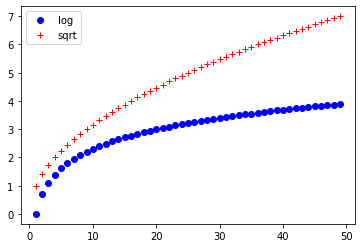

In [ ]:
# Generating curves

x = [n for n in range(1,50)]

y_log = list(map(np.log, x))
y_sqt = list(map(lambda n: n**0.5, x))

plt.plot(x, y_log, 'bo', label='log')
plt.plot(x, y_sqt, 'r+', label='sqrt')
#plt.plot(x, x, 'go--', label='45dg')

plt.legend()
plt.show()



## **Simulating**

TO DO:

*given a a same seed for every simulation*

- calculate IQR for all curves
- calculate how much from each metric is needed to be an outlier (1.5 IQR)
- make box plot for every curve final_score data



#### Similar users

In [120]:
# generating test isntance

test_parameters = {
    'number_of_users_to_generate': 10,
    'total_views_average':100,
    'total_unique_views_average':30,
    'total_prompts_created_average':10,
    'total_curator_views_average': 15,
    'average_curator_score': 10 ,
    'number_of_curator_views':  5,
    'curator_views_compact':True,
    'curator_scores_compact':True,
    'total_views_compact':True,
    'unique_views_compact':True,
    'prompts_compact':True,
    'compact_factor':0.4,
    'extreme_factor':20,
    'extreme_perc': 0.2,
    'curator_scores_extreme':True,
    'total_views_extreme': True,
    'unique_views_extreme': True,
    'prompts_extreme': False,
    'curator_scores_constant': False,
    'total_views_constant': False,
    'unique_views_constant': False,
    'prompts_constant': False,

}

sim_test = TestGenerator(**test_parameters)

,id,is_outlier,is_total_views_outlier,is_unique_views_outlier,is_prompts_outlier,is_curator_views_outlier,total_views,unique_views,prompts_created,curator_views_weighted,final_score,total_views_share,unique_share,prompts_share,curators_share
0,0,True,True,False,False,False,1540,36,7,11.109589,164.843836,0.934218,0.021839,0.016986,0.026958
1,1,True,True,False,False,False,1260,30,12,8.148649,137.059459,0.919309,0.021888,0.035021,0.023781
5,5,True,False,False,False,True,91,41,12,212.054795,102.821918,0.088503,0.039875,0.046683,0.824940
4,4,True,False,False,False,True,102,41,12,202.439024,100.075610,0.101923,0.040969,0.047964,0.809144
2,2,True,False,True,False,False,63,760,6,9.880952,88.652381,0.071064,0.857281,0.027072,0.044583
3,3,True,False,True,False,False,89,580,9,9.761905,74.404762,0.119616,0.779520,0.048384,0.052480
9,9,False,False,False,False,False,130,24,12,9.589041,24.035616,0.540864,0.099852,0.199704,0.159581
6,6,False,False,False,False,False,126,30,11,9.493671,23.797468,0.529468,0.126064,0.184894,0.159574
8,8,False,False,False,False,False,130,37,6,9.360465,22.844186,0.569073,0.161967,0.105060,0.163901
7,7,False,False,False,False,False,124,25,6,10.023529,21.309412,0.581903,0.117319,0.112626,0.188152


In [121]:
equations = [(linear_sum, [0.1, 0.1, 0.4, 0.4]), 
             (log_sum, [0.1, 0.1, 0.4, 0.4])]

multi_dt = pd.DataFrame(sim_test.generate_multiple_comparison(random_seed=1, function_list=equations))



multi_dt.sort_values('final_score', ascending=False)

,id,is_outlier,is_total_views_outlier,is_unique_views_outlier,is_prompts_outlier,is_curator_views_outlier,total_views,unique_views,prompts_created,curator_views_weighted,final_score,total_views_share,unique_share,prompts_share,curators_share,reward_function
0,0,True,True,False,False,False,1540,36,7,11.109589,164.843836,0.934218,0.021839,0.016986,0.026958,linear_sum
1,1,True,True,False,False,False,1260,30,12,8.148649,137.059459,0.919309,0.021888,0.035021,0.023781,linear_sum
5,5,True,False,False,False,True,91,41,12,212.054795,102.821918,0.088503,0.039875,0.046683,0.824940,linear_sum
4,4,True,False,False,False,True,102,41,12,202.439024,100.075610,0.101923,0.040969,0.047964,0.809144,linear_sum
2,2,True,False,True,False,False,63,760,6,9.880952,88.652381,0.071064,0.857281,0.027072,0.044583,linear_sum
3,3,True,False,True,False,False,89,580,9,9.761905,74.404762,0.119616,0.779520,0.048384,0.052480,linear_sum
9,9,False,False,False,False,False,130,24,12,9.589041,24.035616,0.540864,0.099852,0.199704,0.159581,linear_sum
6,6,False,False,False,False,False,126,30,11,9.493671,23.797468,0.529468,0.126064,0.184894,0.159574,linear_sum
8,8,False,False,False,False,False,130,37,6,9.360465,22.844186,0.569073,0.161967,0.105060,0.163901,linear_sum
7,7,False,False,False,False,False,124,25,6,10.023529,21.309412,0.581903,0.117319,0.112626,0.188152,linear_sum
